<a href="https://colab.research.google.com/github/MariaJuliaPareja/Dataset_Frauds_On_Salary/blob/main/DATASET_FRAUDES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Selección del Dataset**

Para este analisis se utilizó el dataset 'salarios_ti.csv', el cual contiene información detallada sobre salarios en el área de tecnología, incluyendo variables como año, puesto de trabajo, categoría, moneda de salario, salario en USD, residencia del empleado, nivel de experiencia, tipo de empleo, modalidad de trabajo, ubicación de la empresa y tamaño de la empresa.

Este conjunto de datos permite analizar los factores más relevantes que influyen en los salarios del sector TI a nivel global, con el objetivo de predecir el salario en USD basado en las características del puesto, experiencia y condiciones laborales. Como adicional se podria determinar si una oferta salarial está subpagada, en el promedio o sobrepagada según los estándares actuales del mercado.


In [ ]:
#librerias escenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#librerias de preprocesamiento y modelo
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
#libreriasde evaluación
from sklearn.metrics import classification_report, confusion_matrix
# Configurar el estilo de las gráficas
sns.set_theme(style="whitegrid")

file_name = 'DATASET.csv'
df = pd.read_csv(file_name, sep=';')

print(f"Forma del dataset (filas, columnas): {df.shape}")
print("\nInformación General y Tipos de Datos")
df.info()

print("\n--- Primeras 5 filas del Dataset ---")
df.head()

Forma del dataset (filas, columnas): (24987, 20)

Información General y Tipos de Datos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24987 entries, 0 to 24986
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data_rif           24987 non-null  object 
 1   userid             24987 non-null  int64  
 2   age                24987 non-null  int64  
 3   profession         24800 non-null  object 
 4   region             24797 non-null  object 
 5   account_balance    24987 non-null  float64
 6   num_trx_cd         24787 non-null  float64
 7   num_trx_cc         24768 non-null  float64
 8   num_trx_cp         24785 non-null  float64
 9   num_mov_conto      24987 non-null  int64  
 10  sum_mov_conto_pos  24987 non-null  int64  
 11  sum_mov_conto_neg  24987 non-null  int64  
 12  num_prodotti       24987 non-null  int64  
 13  f2                 24987 non-null  int64  
 14  f3                 24987 non-nu

,data_rif,userid,age,profession,region,account_balance,num_trx_cd,num_trx_cc,num_trx_cp,num_mov_conto,sum_mov_conto_pos,sum_mov_conto_neg,num_prodotti,f2,f3,f4,f5,f6,f7,TARGET
0,2022-07-31,1000510,23,Lavoratore autonomo,TOSCANA,65627.799269,0.0,0.0,0.0,10,3590,-370,2,88,60,8,20,21.141686,0.268369,0
1,2022-07-31,1001511,55,Lavoratore dipendente,BASILICATA,39335.109963,7.0,0.0,0.0,0,0,0,5,97,63,11,82,38.169452,0.672864,1
2,2022-07-31,1001726,23,Lavoratore autonomo,PUGLIA,-37466.828926,148.0,0.0,0.0,2,636,-294,10,90,49,31,71,38.602380,0.126743,0
3,2022-07-31,1002418,43,Studente,VALLE AOSTA,13864.880197,215.0,0.0,0.0,8,1064,-1640,3,99,66,52,57,31.505413,2.081956,1
4,2022-07-31,1002646,26,Studente,LOMBARDIA,-32625.910843,38.0,56.0,6.0,0,0,0,1,115,56,44,28,36.882651,0.210746,0


#DEFINICION DE VARIABLES


In [ ]:
#Variable Target
#Esta variable no se usara para entrenar el modelo, solo se usará al final para EVALUAR los resultados.
target_variable = 'TARGET'

#Variables Predictoras (Features)
#Estas son las columnas que usará el modelo para aprender que es lo normal
features = [col for col in df.columns if col not in ['TARGET', 'data_rif', 'userid']]

#Separamos las features por tipo para facilitar la transformación
categorical_features = ['profession', 'region']
numerical_features = [f for f in features if f not in categorical_features]

print(f"Variable Objetivo (solo para evaluacion posterior): {target_variable}")
print(f"\nVariables Categoricas ({len(categorical_features)}): {categorical_features}")
print(f"\nVariables Numericas ({len(numerical_features)}): {numerical_features}")

Variable Objetivo (solo para evaluacion posterior): TARGET

Variables Categoricas (2): ['profession', 'region']

Variables Numericas (15): ['age', 'account_balance', 'num_trx_cd', 'num_trx_cc', 'num_trx_cp', 'num_mov_conto', 'sum_mov_conto_pos', 'sum_mov_conto_neg', 'num_prodotti', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']


#Procesos de Limpieza y Transformacion

---



In [ ]:
#revisar valores missing
missing_values = df.isnull().sum().sum()
if missing_values == 0:
    print("Estado: El dataset no tiene valores faltantes.")
else:
    print(f"jeje: El dataset tiene {missing_values} valores faltantes. Se deben tratar.")
#Creamos una copia de seguridad
df_procesado = df.copy()

jeje: El dataset tiene 998 valores faltantes. Se deben tratar.


Eliminar columnas irrelevantes

In [ ]:
# data_rif y userid no son features de comportamiento
df_procesado = df_procesado.drop(columns=['data_rif', 'userid'])
print("Columnas 'data_rif' y 'userid' eliminadas.")

Columnas 'data_rif' y 'userid' eliminadas.


Encoding de Variables Categóricas

In [ ]:
# Convertimos texto('profession', 'region') en numeros usando la tecnica de One-Hot Encoding
df_procesado = pd.get_dummies(df_procesado, columns=categorical_features, drop_first=True)
print(f"Variables categóricas '{categorical_features}' convertidas a One-Hot Encoding.")

Variables categóricas '['profession', 'region']' convertidas a One-Hot Encoding.


Estandarización de Variables Numéricas

In [ ]:
# Escalamos todo a media 0 y desviación estándar 1.
scaler = StandardScaler()

Nuevas columnas sin el target

In [ ]:
#las nuevas features son todas las columnas menos TARGET
features_procesadas = [col for col in df_procesado.columns if col != target_variable]

Aplicamos el escalado solo a las columnas numéricas originales

In [ ]:

#las columnas dummy ya estan el la escala 0 y 1
cols_a_escalar = [col for col in numerical_features if col in df_procesado.columns]
df_procesado[cols_a_escalar] = scaler.fit_transform(df_procesado[cols_a_escalar])
print(f"Variables numéricas estandarizadas.")

Variables numéricas estandarizadas.


Dataset listo

In [ ]:
print("Dataset Final Preparado (Primeras 5 filas)")
print(f"\nNúmero total de variables predictoras para el modelo: {len(features_procesadas)}")
df_procesado.head()



Dataset Final Preparado (Primeras 5 filas)

Número total de variables predictoras para el modelo: 38


,age,account_balance,num_trx_cd,num_trx_cc,num_trx_cp,num_mov_conto,sum_mov_conto_pos,sum_mov_conto_neg,num_prodotti,f2,...,region_MOLISE,region_PIEMONTE,region_PUGLIA,region_SARDEGNA,region_SICILIA,region_TOSCANA,region_TRENTINO-ALTO ADIGE,region_UMBRIA,region_VALLE AOSTA,region_VENETO
0,-0.484889,0.647855,-0.730184,-0.679441,-0.679584,0.048488,0.297759,0.469391,-0.508186,-0.563533,...,False,False,False,False,False,True,False,False,False,False
1,2.456919,0.385493,-0.624331,-0.679441,-0.679584,-0.676357,-0.552336,0.557250,0.404335,-0.283081,...,False,False,False,False,False,False,False,False,False,False
2,-0.484889,-0.380876,1.507836,-0.679441,-0.679584,-0.531388,-0.401734,0.487438,1.925204,-0.501211,...,False,False,True,False,False,False,False,False,False,False
3,1.353741,0.131338,2.520993,-0.679441,-0.679584,-0.096481,-0.300386,0.167822,-0.204012,-0.220758,...,False,False,False,False,False,False,False,False,True,False
4,-0.209095,-0.332571,-0.155557,0.886886,-0.463804,-0.676357,-0.552336,0.557250,-0.812359,0.277823,...,False,False,False,False,False,False,False,False,False,False


#Analisis monovariado

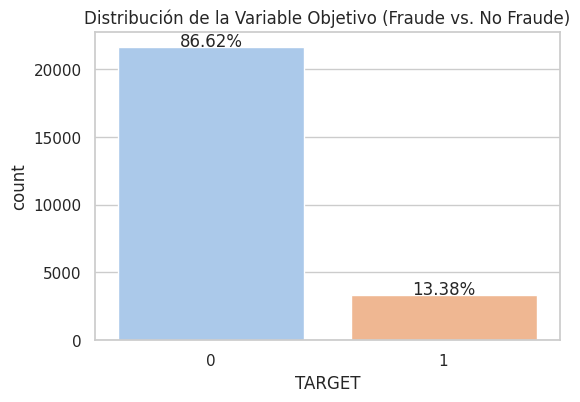

Interpretación: El dataset está altamente desbalanceado. Solo el 13.38% de los clientes son fraude.
Boxplots de Variables Clave antes su estandarización


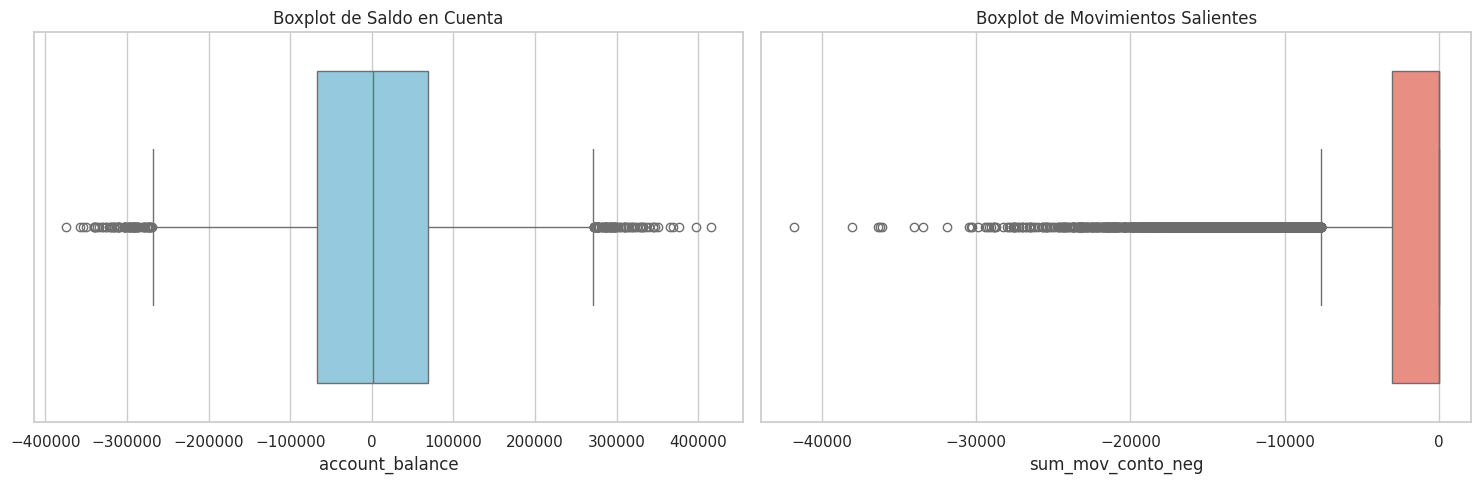

Interpretación: Vemos muchos outliers, especialmente en las variables de transacciones. Nuestro modelo de anomalías intentará capturar a estos clientes.


In [ ]:
#Distribución de la variable TARGET
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df,
    x=target_variable,
    palette='pastel',
    hue=target_variable,
    legend=False
)
plt.title('Distribución de la Variable Objetivo (Fraude vs. No Fraude)')
total = len(df)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            f'{height/total:.2%}',
            ha="center")
plt.show()
print(f"Interpretación: El dataset está altamente desbalanceado. Solo el {df[target_variable].mean():.2%} de los clientes son fraude.")
print("Boxplots de Variables Clave antes su estandarización")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=df['account_balance'], ax=axes[0], color='skyblue')
axes[0].set_title('Boxplot de Saldo en Cuenta')
sns.boxplot(x=df['sum_mov_conto_neg'], ax=axes[1], color='salmon')
axes[1].set_title('Boxplot de Movimientos Salientes')

plt.tight_layout()
plt.show()
print("Interpretación: Vemos muchos outliers, especialmente en las variables de transacciones. Nuestro modelo de anomalías intentará capturar a estos clientes.")


#Analisis multivariado

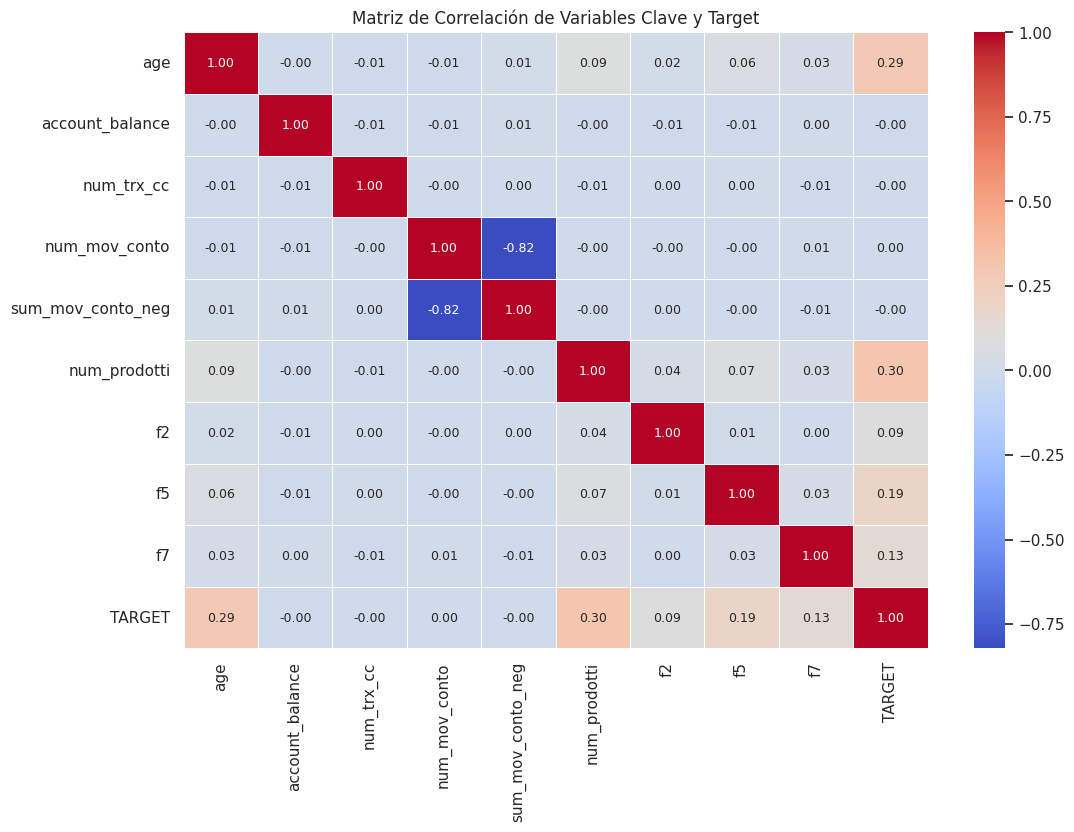

Interpretación: Buscamos correlaciones con TARGET. Aunque el modelo no las usará para entrenar, nos da una pista de qué 'features' podrían ser importantes para definir una anomalía que resulte ser fraude.


In [ ]:
#Matriz de Correlación (Heatmap)
# Seleccionamos solo un subconjunto de features numéricas + target para legibilidad
features_interes = ['age', 'account_balance', 'num_trx_cc', 'num_mov_conto',
                    'sum_mov_conto_neg', 'num_prodotti', 'f2', 'f5', 'f7', 'TARGET']
plt.figure(figsize=(12, 8))
corr_matrix = df[features_interes].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, annot_kws={"size": 9})
plt.title('Matriz de Correlación de Variables Clave y Target')
plt.show()
print("Interpretación: Buscamos correlaciones con TARGET. Aunque el modelo no las usará para entrenar, nos da una pista de qué 'features' podrían ser importantes para definir una anomalía que resulte ser fraude.")

# Mineria de datos (enfoque no supervisado) recall promedio del 15 %

In [ ]:
# X_full serán nuestros features
X_full = df_procesado.drop(columns=[target_variable])
# y_full será nuestra "verdad absoluta" para evaluar
y_full = df_procesado[target_variable]

# Arreglar nans creados por standarsacaler en columnas con varianza cero
nans_en_X = X_full.isnull().sum().sum()
if nans_en_X > 0:
    X_full = X_full.fillna(0)
else:
    print("X_full está limpio")

# Tasa de fraude real (nuestra 'contaminación' base)
real_fraud_rate = y_full.mean()
print(f"Dataset listo. Tasa de fraude real (Contaminación base): {real_fraud_rate:.4f}")

Dataset listo. Tasa de fraude real (Contaminación base): 0.1338


2. Definir el modelo intento 01 (Isolation Forest)

In [ ]:

model_if_base = IsolationForest(
    contamination=real_fraud_rate,
    random_state=42,
    n_jobs=-1
)
y_pred_base = model_if_base.fit_predict(X_full)
y_pred_base_mapped = [1 if pred == -1 else 0 for pred in y_pred_base]

print(classification_report(y_full, y_pred_base_mapped, target_names=['Normal (0)', 'Fraude (1)']))

              precision    recall  f1-score   support

  Normal (0)       0.88      0.88      0.88     21643
  Fraude (1)       0.24      0.24      0.24      3344

    accuracy                           0.80     24987
   macro avg       0.56      0.56      0.56     24987
weighted avg       0.80      0.80      0.80     24987



Afinacion del isolation forest

In [ ]:
print("\n IsolationForest Estricto (cont=5%)] ")
model_if_strict = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
y_pred_strict = model_if_strict.fit_predict(X_full)
y_pred_strict_mapped = [1 if pred == -1 else 0 for pred in y_pred_strict]
print(classification_report(y_full, y_pred_strict_mapped, target_names=['Normal (0)', 'Fraude (1)']))

print("\nIsolationForest Amplio (cont=50%)]")
model_if_wide = IsolationForest(contamination=0.5, random_state=42, n_jobs=-1)
y_pred_wide = model_if_wide.fit_predict(X_full)
y_pred_wide_mapped = [1 if pred == -1 else 0 for pred in y_pred_wide]
print(classification_report(y_full, y_pred_wide_mapped, target_names=['Normal (0)', 'Fraude (1)']))


 IsolationForest Estricto (cont=5%)] 
              precision    recall  f1-score   support

  Normal (0)       0.87      0.96      0.91     21643
  Fraude (1)       0.27      0.10      0.15      3344

    accuracy                           0.84     24987
   macro avg       0.57      0.53      0.53     24987
weighted avg       0.79      0.84      0.81     24987


IsolationForest Amplio (cont=50%)]
              precision    recall  f1-score   support

  Normal (0)       0.91      0.53      0.67     21643
  Fraude (1)       0.18      0.68      0.29      3344

    accuracy                           0.55     24987
   macro avg       0.55      0.60      0.48     24987
weighted avg       0.82      0.55      0.62     24987



Probando modelo local outlier

In [ ]:
print("\nLocal Outlier Factor (LOF) (cont=13.38%)]")
model_lof = LocalOutlierFactor(
    contamination=real_fraud_rate,
    n_jobs=-1
)
y_pred_lof = model_lof.fit_predict(X_full)
y_pred_lof_mapped = [1 if pred == -1 else 0 for pred in y_pred_lof]
print(classification_report(y_full, y_pred_lof_mapped, target_names=['Normal (0)', 'Fraude (1)']))


Local Outlier Factor (LOF) (cont=13.38%)]
              precision    recall  f1-score   support

  Normal (0)       0.88      0.88      0.88     21643
  Fraude (1)       0.24      0.24      0.24      3344

    accuracy                           0.80     24987
   macro avg       0.56      0.56      0.56     24987
weighted avg       0.80      0.80      0.80     24987



Enfoque contextual con clustering

In [ ]:
print("\n Raros 2.0 (KMeans + IF por Cluster)]")
k_clusters = 5
print(f"Creando {k_clusters} clusters con K-Means")
kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
X_full['cluster'] = kmeans.fit_predict(X_full)

predicciones_finales = []
realidad_final = []

print("Buscando anomalias dentro de cada cluster")
for i in range(k_clusters):
    cluster_data = X_full[X_full['cluster'] == i]
    cluster_y = y_full[X_full['cluster'] == i]
    cluster_X = cluster_data.drop(columns=['cluster'])

    if len(cluster_X) == 0: continue

    local_fraud_rate = cluster_y.mean()
    contamination = max(local_fraud_rate, 0.01) # Usar tasa local

    model_if_cluster = IsolationForest(contamination=contamination, random_state=42, n_jobs=-1)
    y_pred_cluster = model_if_cluster.fit_predict(cluster_X)
    y_pred_mapped = [1 if pred == -1 else 0 for pred in y_pred_cluster]

    predicciones_finales.extend(y_pred_mapped)
    realidad_final.extend(cluster_y)

    print(f"\n Reporte Individual (Cluster {i}) | Tasa Fraude: {local_fraud_rate:.2%} ---")
    print(classification_report(cluster_y, y_pred_mapped, target_names=['Normal (0)', 'Fraude (1)']))

print("\n CONSOLIDADO (Raros 2.0) ---")
print(classification_report(realidad_final, predicciones_finales, target_names=['Normal (0)', 'Fraude (1)']))


 Raros 2.0 (KMeans + IF por Cluster)]
Creando 5 clusters con K-Means
Buscando anomalias dentro de cada cluster

 Reporte Individual (Cluster 0) | Tasa Fraude: 43.77% ---
              precision    recall  f1-score   support

  Normal (0)       0.58      0.58      0.58      1639
  Fraude (1)       0.46      0.46      0.46      1276

    accuracy                           0.52      2915
   macro avg       0.52      0.52      0.52      2915
weighted avg       0.52      0.52      0.52      2915


 Reporte Individual (Cluster 1) | Tasa Fraude: 18.64% ---
              precision    recall  f1-score   support

  Normal (0)       0.83      0.83      0.83      4059
  Fraude (1)       0.28      0.28      0.28       930

    accuracy                           0.73      4989
   macro avg       0.56      0.56      0.56      4989
weighted avg       0.73      0.73      0.73      4989


 Reporte Individual (Cluster 2) | Tasa Fraude: 4.16% ---
              precision    recall  f1-score   support

  N



# Enfoque Supervisado (random forest) recall promedio del 91%





1. Importar librerias y preparar los datos


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# X_full serán nuestros features
X_full = df_procesado.drop(columns=[target_variable])
# y_full será nuestra "verdad absoluta" para evaluar
y_full = df_procesado[target_variable]

# Arreglar nans creados por standarsacaler en columnas con varianza cero
nans_en_X = X_full.isnull().sum().sum()
if nans_en_X > 0:
    X_full = X_full.fillna(0)
else:
    print("X_full está limpio")

if 'cluster' in X_full.columns:
    X_full = X_full.drop(columns=['cluster'])
else:
    print("X_full sin clusters")

feature_names = X_full.columns

X_full sin clusters



2. División de Datos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.30,
    random_state=42,
    stratify=y_full # ¡Crucial para desbalance!
)
print(f"Set de entrenamiento: {X_train.shape[0]} muestras")
print(f"Set de pruebas: {X_test.shape[0]} muestras para evaluacion")

Set de entrenamiento: 17490 muestras
Set de pruebas: 7497 muestras para evaluacion


3. Balanceo de Datos con smote

In [ ]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Forma de y_train luego de aplicar snmote: {y_train_balanced.value_counts().to_dict()}")

Forma de y_train luego de aplicar snmote: {0: 15149, 1: 15149}


4. Minería de Datos

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

#entrenamiento con datos balancea2
rf_model.fit(X_train_balanced, y_train_balanced)
print("Correcto")

Correcto


Evaluacion


--- Reporte de Clasificación (RandomForest Supervisado) ---
              precision    recall  f1-score   support

  Normal (0)       0.97      0.98      0.98      6494
  Fraude (1)       0.89      0.83      0.86      1003

    accuracy                           0.96      7497
   macro avg       0.93      0.91      0.92      7497
weighted avg       0.96      0.96      0.96      7497


--- Las 'Huellas Dactilares' del Fraude ---
Las 10 pistas (features) más importantes que usó el modelo:
        feature  importance
   num_prodotti    0.358135
             f6    0.142168
            age    0.109164
             f5    0.105416
             f2    0.056469
             f4    0.051862
             f3    0.039405
             f7    0.023718
account_balance    0.013094
     num_trx_cd    0.012028

Generando gráfico de importancia de features...


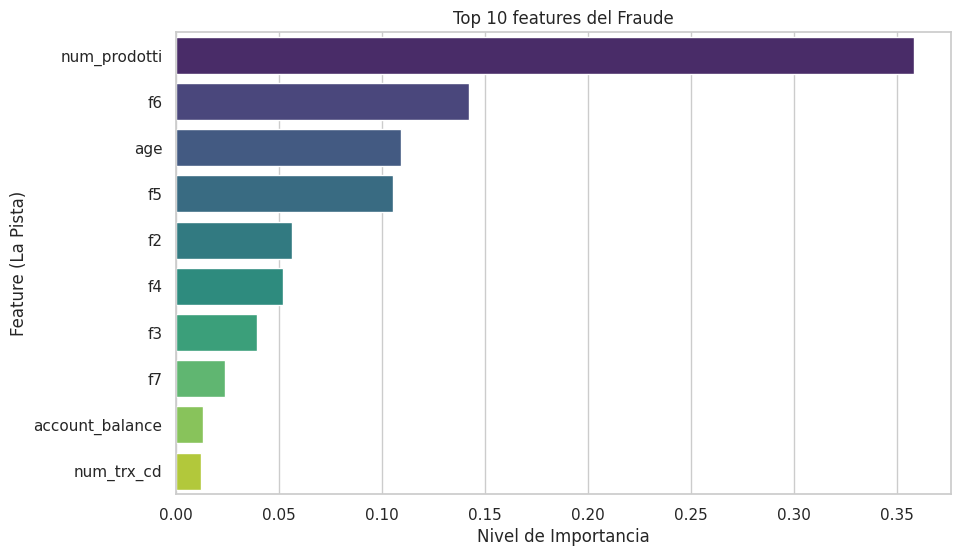

In [ ]:

# 1. Evaluación del rendimiento
y_pred = rf_model.predict(X_test)

print("\n--- Reporte de Clasificación (RandomForest Supervisado) ---")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fraude (1)']))


# 2. Explicación (Las 'Huellas Dactilares')
print("\n--- Las 'Huellas Dactilares' del Fraude ---")
print("Las 10 pistas (features) más importantes que usó el modelo:")

# Obtenemos la importancia de cada feature
importances = rf_model.feature_importances_

# Creamos un DataFrame para verlas fácilmente
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Mostramos las 10 más importantes
print(feature_importance_df.head(10).to_string(index=False))

# Graficamos las 10 más importantes
print("\nGenerando gráfico de importancia de features...")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.head(10),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title('Top 10 features del Fraude')
plt.xlabel('Nivel de Importancia')
plt.ylabel('Feature (La Pista)')
plt.show()

# Enfoque Supervisado (XGBoost) recall promedio del 95.5%


1. Importar Librerías y Preparar los Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Librerías de Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

# Importar el 'Rey': XGBoost
try:
    from xgboost import XGBClassifier
except ModuleNotFoundError:
    print("="*50)
    print("ERROR: La librería 'xgboost' no está instalada.")
    print("En Google Colab, ejecuta en una celda: !pip install xgboost")
    print("="*50)
    raise

# Configuraciones
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_theme(style="whitegrid")

# Carga y Preparacion
print("\nCargando y preprocesando los datos...")

# Carga
file_name = 'DATASET.csv'
try:
    df = pd.read_csv(file_name, sep=';')
except FileNotFoundError:
    print(f"Error: No se encontró '{file_name}'. Súbelo a tu Colab.")
    raise

# Definición de Variables
target_variable = 'TARGET'
categorical_features = ['profession', 'region']
numerical_features = [col for col in df.columns if col not in
                      ['TARGET', 'data_rif', 'userid', 'profession', 'region']]

# Preprocesamiento
df_procesado = df.copy()
df_procesado = df_procesado.drop(columns=['data_rif', 'userid'])
df_procesado = pd.get_dummies(df_procesado, columns=categorical_features, drop_first=True)

# Escalado
scaler = StandardScaler()
cols_a_escalar = [col for col in numerical_features if col in df_procesado.columns]
df_procesado[cols_a_escalar] = scaler.fit_transform(df_procesado[cols_a_escalar])

# Separación final de X (features) e y (target)
X_full = df_procesado.drop(columns=[target_variable])
y_full = df_procesado[target_variable]

# Parche de NaNs (creados por StandardScaler si hay varianza cero)
nans_en_X = X_full.isnull().sum().sum()
if nans_en_X > 0:
    print(f"Aplicando parche: Rellenando {nans_en_X} NaNs (creados por StandardScaler) con 0...")
    X_full = X_full.fillna(0)

feature_names = X_full.columns.tolist()



Cargando y preprocesando los datos...
Aplicando parche: Rellenando 621 NaNs (creados por StandardScaler) con 0...


2. División de Datos

In [ ]:
print("Dividiendo datos en Entrenamiento (70%) y Prueba (30%)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.30,
    random_state=42,
    stratify=y_full # Mantiene la proporción de fraude
)
print(f"Set de Entrenamiento: {X_train.shape[0]} muestras")
print(f"Set de Prueba: {X_test.shape[0]} muestras")

Dividiendo datos en Entrenamiento (70%) y Prueba (30%)...
Set de Entrenamiento: 17490 muestras
Set de Prueba: 7497 muestras


3. Balanceo de Datos

In [ ]:
print("Calculando peso para balanceo (sin SMOTE)...")
conteo_clases = y_train.value_counts()
scale_pos_weight = conteo_clases[0] / conteo_clases[1]
print(f"   Peso para 'scale_pos_weight' de XGBoost: {scale_pos_weight:.2f}")

Calculando peso para balanceo (sin SMOTE)...
   Peso para 'scale_pos_weight' de XGBoost: 6.47


4. Minería de Datos (Entrenamiento)

In [ ]:

xgb_model = XGBClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)

5. Evaluacion


--- 5. FASE DE EVALUACIÓN ---

--- 5a. Evaluación Base (con umbral 0.5 por defecto) ---
              precision    recall  f1-score   support

  Normal (0)       0.99      1.00      0.99      6494
  Fraude (1)       0.97      0.92      0.95      1003

    accuracy                           0.99      7497
   macro avg       0.98      0.96      0.97      7497
weighted avg       0.99      0.99      0.99      7497

Interpretación: Este es el 'recall' base antes de optimizar.

--- 5b. Optimizando Umbral para Recall > 90% ---
   Objetivo de Recall > 90% alcanzado.
   Mejor Threshold (Umbral): 0.61
   Recall Resultante: 90.53% 
   Precisión Resultante: 98.16%

--- Reporte de Clasificación Final (con Umbral Optimizado) ---
              precision    recall  f1-score   support

  Normal (0)       0.99      1.00      0.99      6494
  Fraude (1)       0.98      0.91      0.94      1003

    accuracy                           0.99      7497
   macro avg       0.98      0.95      0.97      7497
we

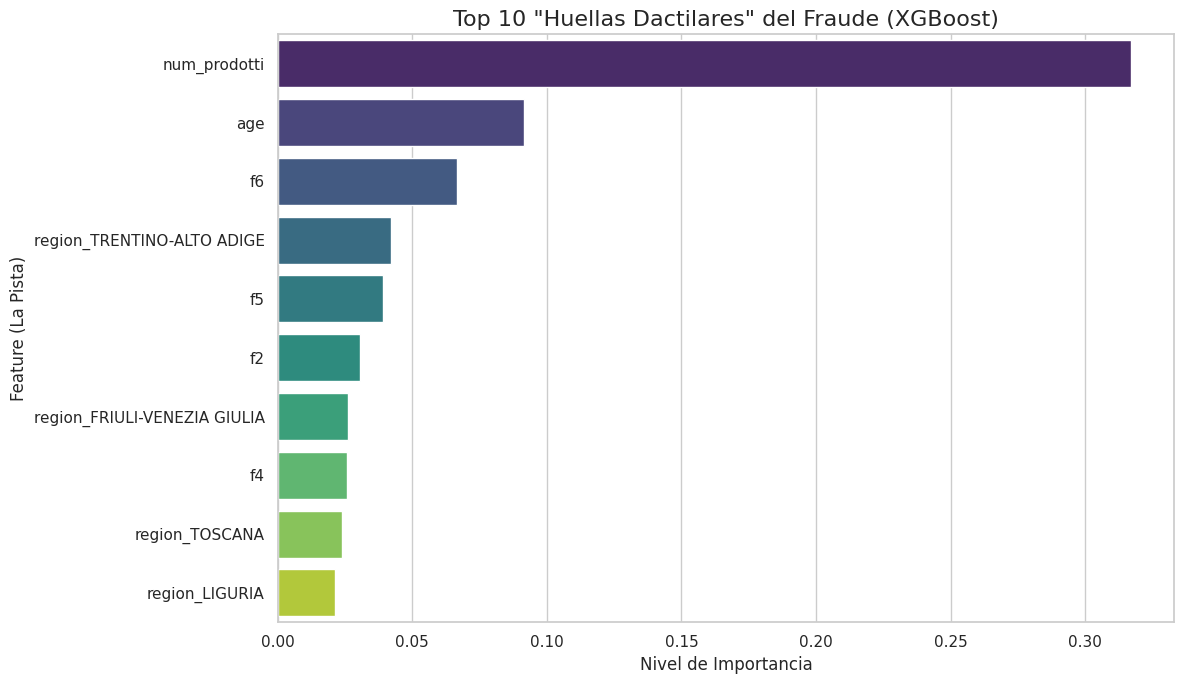

In [ ]:
print("\n" + "="*50)
print("--- 5. FASE DE EVALUACIÓN ---")
print("="*50)

# --- 5a. Evaluación Base (Threshold 0.5) ---
print("\n--- 5a. Evaluación Base (con umbral 0.5 por defecto) ---")
y_pred_base = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_base, target_names=['Normal (0)', 'Fraude (1)']))
print("Interpretación: Este es el 'recall' base antes de optimizar.")

# --- 5b. Optimización de Threshold para >90% Recall ---
print("\n--- 5b. Optimizando Umbral para Recall > 90% ---")

# Obtenemos las probabilidades de fraude (clase '1')
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Probamos umbrales de 0.01 a 0.99
thresholds = np.arange(0.01, 1.0, 0.01)
metricas = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    metricas.append({
        'threshold': thresh,
        'recall': recall,
        'precision': precision
    })

df_thresh = pd.DataFrame(metricas)
opciones_90 = df_thresh[df_thresh['recall'] >= 0.90]

if len(opciones_90) > 0:
    # De ellas, elegir la de MAYOR PRECISIÓN
    mejor_resultado = opciones_90.loc[opciones_90['precision'].idxmax()]

    print(f"   Objetivo de Recall > 90% alcanzado.")
    print(f"   Mejor Threshold (Umbral): {mejor_resultado['threshold']:.2f}")
    print(f"   Recall Resultante: {mejor_resultado['recall']*100:.2f}% ")
    print(f"   Precisión Resultante: {mejor_resultado['precision']*100:.2f}%")
    y_pred_final = (y_proba >= mejor_resultado['threshold']).astype(int)

else:
    mejor_recall = df_thresh.loc[df_thresh['recall'].idxmax()]
    print(f"      No se alcanzó 90% recall.")
    print(f"      Máximo Recall posible: {mejor_recall['recall']*100:.2f}%")
    print(f"      (Con Threshold: {mejor_recall['threshold']:.2f})")

    y_pred_final = (y_proba >= mejor_recall['threshold']).astype(int)

print("\n--- Reporte de Clasificación Final (con Umbral Optimizado) ---")
print(classification_report(y_test, y_pred_final, target_names=['Normal (0)', 'Fraude (1)']))

#Feature Importance
print("\n5c Feature Importance")

importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nLas 10 pistas (features) más importantes que usó XGBoost:")
print(feature_importance_df.head(10).to_string(index=False))

# Gráfico
print("\nGenerando gráfico de importancia de features...")
plt.figure(figsize=(12, 7))
sns.barplot(
    data=feature_importance_df.head(10),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title('Top 10 "Huellas Dactilares" del Fraude (XGBoost)', fontsize=16)
plt.xlabel('Nivel de Importancia', fontsize=12)
plt.ylabel('Feature (La Pista)', fontsize=12)
plt.tight_layout()
plt.show()



# METODOLOGÍA DE VALIDACIÓN Y AFINAMIENTO DE MODELOS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#Herramientas de Preprocesamiento y Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Modelos y Herramientas de Evaluación
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#Configuración de entorno
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_theme(style="whitegrid")

1. Carga del dataset y división de Datos

In [ ]:
file_name = 'DATASET.csv'
df_raw = pd.read_csv(file_name, sep=';')
print(f"Dataset cargado. Forma: {df_raw.shape}")

#Definición de Features (X) y Target (y)
target_variable = 'TARGET'
X = df_raw.drop(columns=[target_variable, 'data_rif', 'userid'])
y = df_raw[target_variable]

categorical_features = ['profession', 'region']
numerical_features = [col for col in X.columns if col not in categorical_features]

print(f"Features numerias: {len(numerical_features)}")
print(f"Features categóricas: {len(categorical_features)}")

#1.2 División en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,  #20% para la evaluacion final
    random_state=42,
    stratify=y
)

print(f"Set de Entrenamiento (para CV y Tuning): {X_train.shape[0]} muestras")
print(f"Set de Prueba (para Evaluación Final): {X_test.shape[0]} muestras")
print("Fase 1 completada.")

Dataset cargado. Forma: (24987, 20)
Features numerias: 15
Features categóricas: 2
Set de Entrenamiento (para CV y Tuning): 19989 muestras
Set de Prueba (para Evaluación Final): 4998 muestras
Fase 1 completada.


2. Pipeline de preprocesamiento y de los 5 modelos

In [ ]:
#Creacion de transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantiene columnas no especificadas (si las hubiera)
)

#pipeline para features numericas:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#pipeline para features categoricas:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

#calcular 'scale_pos_weight' para XGBoost
conteo_clases_train = y_train.value_counts()
scale_pos_weight = conteo_clases_train[0] / conteo_clases_train[1]

#combinar transformadores con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

modelos_base = {
    'RandomForest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced' #manejo de desbalance interno
    ),
    'XGBoost': XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight #manejo de desbalance interno
    ),
    'GradientBoosting': GradientBoostingClassifier(
        random_state=42
        #GBC no tiene un parámetro de balanceo simple.
    ),
    'LogisticRegression': LogisticRegression(
        random_state=42,
        class_weight='balanced',
        max_iter=1000 #aumentar iteraciones para asegurar convergencia
    ),
    'LinearSVC': LinearSVC(
        random_state=42,
        class_weight='balanced',
        dual=False, #recomendado cuando n_samples > n_features
        max_iter=1000
    )}

pipelines_completos = {}
for nombre, modelo in modelos_base.items():
    pipelines_completos[nombre] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', modelo)
    ])

print("Pipelines de preprocesamiento y modelo creados exitosamente.")
print(f"Modelos a comparar: {list(pipelines_completos.keys())}")

Pipelines de preprocesamiento y modelo creados exitosamente.
Modelos a comparar: ['RandomForest', 'XGBoost', 'GradientBoosting', 'LogisticRegression', 'LinearSVC']


3. Validación Cruzada (10 folds) y Análisis Estadístico


Ejecutando validación cruzada de 10 pliegues.
Métrica de puntuación: roc_auc


<>:33: SyntaxWarning: invalid escape sequence '\E'
<>:33: SyntaxWarning: invalid escape sequence '\E'
/tmp/ipython-input-2531462985.py:33: SyntaxWarning: invalid escape sequence '\E'
  print("\Ejecucion de pruebas de Friedman para diferencias estadisticas")


   RandomForest | roc_auc (media): 0.9890 (std: 0.0018)
   XGBoost | roc_auc (media): 0.9947 (std: 0.0014)
   GradientBoosting | roc_auc (media): 0.9896 (std: 0.0019)
   LogisticRegression | roc_auc (media): 0.8584 (std: 0.0130)
   LinearSVC | roc_auc (media): 0.8585 (std: 0.0129)

Generacion de analisis grafico de métricas por pliegues


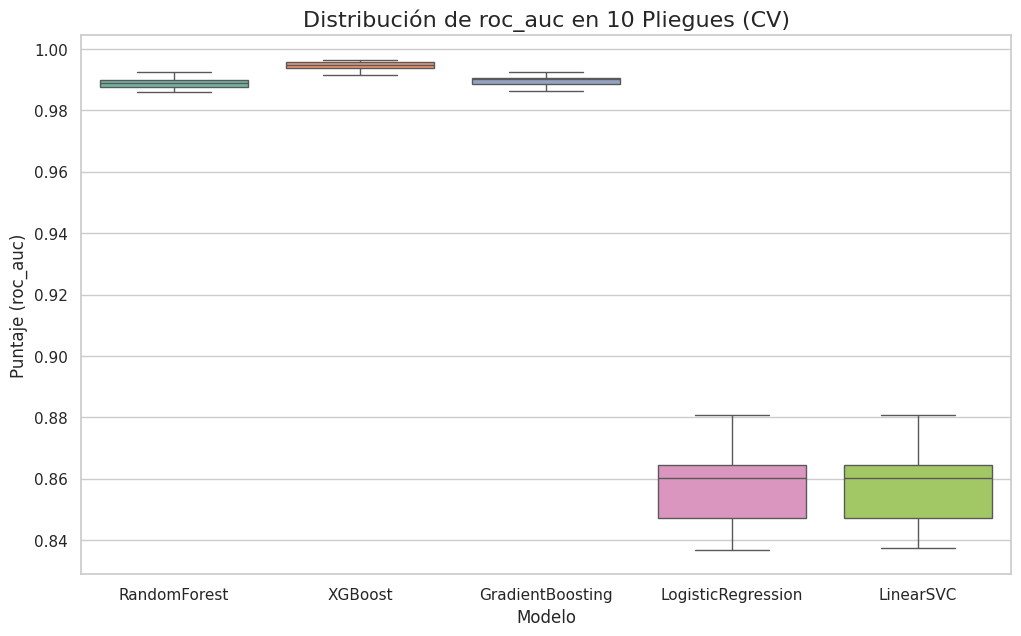

\Ejecucion de pruebas de Friedman para diferencias estadisticas
   Estadístico F de Friedman: 36.4000
   Valor-p: 0.0000
Se detecta una diferencia estadística significativa entre los modelos.


In [ ]:
N_SPLITS = 10
SCORING_METRIC = 'roc_auc'

print(f"Ejecutando validación cruzada de {N_SPLITS} pliegues.")
print(f"Métrica de puntuación: {SCORING_METRIC}")

# Objeto de Validación Cruzada (Estratificado)
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Almacenar resultados de la validación cruzada
cv_results = {}
for nombre, pipeline in pipelines_completos.items():

    # Usamos X_train y y_train (el 80% de los datos)
    scores = cross_val_score(pipeline, X_train, y_train,
                             cv=kfold,
                             scoring=SCORING_METRIC,
                             n_jobs=-1)

    cv_results[nombre] = scores
    print(f"   {nombre} | {SCORING_METRIC} (media): {scores.mean():.4f} (std: {scores.std():.4f})")

print("\nGeneracion de analisis grafico de métricas por pliegues")
df_cv_results = pd.DataFrame(cv_results)

plt.figure(figsize=(12, 7))
sns.boxplot(data=df_cv_results, palette='Set2')
plt.title(f'Distribución de {SCORING_METRIC} en {N_SPLITS} Pliegues (CV)', fontsize=16)
plt.ylabel(f'Puntaje ({SCORING_METRIC})')
plt.xlabel('Modelo')
plt.show()

print("\Ejecucion de pruebas de Friedman para diferencias estadisticas")

try:
    f_statistic, p_value = stats.friedmanchisquare(*df_cv_results.values.T)
    print(f"   Estadístico F de Friedman: {f_statistic:.4f}")
    print(f"   Valor-p: {p_value:.4f}")

    if p_value < 0.05:
        print("Se detecta una diferencia estadística significativa entre los modelos.")
    else:
        print("No hay diferencia estadística significativa entre los modelos.")

except ValueError as e:
    print(f"   Error al ejecutar Friedman test: {e}")


4. Hiperparametrización (GridSearchCV)

In [ ]:
# --- Bloque 4 (Corregido): Hiperparametrización (GridSearchCV con k=10) ---

# Importamos la herramienta para los pliegues
from sklearn.model_selection import StratifiedKFold

print("\n" + "="*50)
print("--- [FASE 4: Hiperparametrización (GridSearchCV k=10)] ---")
print("Buscando los mejores hiperparámetros para los 5 modelos...")

# --- 4.1. Definir Grillas de Búsqueda de Parámetros ---
# (Las grillas que definiste son correctas)

# Grid para RandomForest
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__min_samples_leaf': [1, 5]
}

# Grid para XGBoost
param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [5, 10]
}

# Grid para GradientBoosting
param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [5, 10]
}

# Grid para LogisticRegression
param_grid_lr = {
    'model__C': [0.01, 0.1, 1.0, 10.0],
    'model__solver': ['liblinear']
}

# Grid para LinearSVC
param_grid_svc = {
    'model__C': [0.01, 0.1, 1.0, 10.0]
}

# --- 4.2. Configurar y Ejecutar GridSearchCV (CON k=10) ---

# Cambio 1
N_SPLITS_FOR_TUNING = 10

# --- CAMBIO IMPORTANTE 2 ---
# Creamos un objeto KFold estratificado para pasarlo a GridSearchCV
# Esto asegura que el desbalance de 13% se mantenga en cada pliegue
kfold_for_tuning = StratifiedKFold(n_splits=N_SPLITS_FOR_TUNING,
                                   shuffle=True,
                                   random_state=42)

SCORING_FOR_TUNING = 'recall_macro' # Optimiza el recall de ambas clases

print(f"Iniciando GridSearchCV (CV={N_SPLITS_FOR_TUNING} pliegues, scoring={SCORING_FOR_TUNING})...")
print("ADVERTENCIA: Este proceso tardará el doble que el anterior (k=5).")

# Diccionario para guardar los mejores modelos ya afinados
best_estimators = {}

# --- Tuning RandomForest ---
print("\n   Afinando RandomForest...")
grid_rf = GridSearchCV(
    pipelines_completos['RandomForest'],
    param_grid=param_grid_rf,
    cv=kfold_for_tuning, # <-- Pasamos el k-fold estratificado
    scoring=SCORING_FOR_TUNING,
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train, y_train)
best_estimators['RandomForest'] = grid_rf.best_estimator_
print(f"   Mejores parámetros (RF): {grid_rf.best_params_}")
print(f"   Mejor puntaje (RF) en CV: {grid_rf.best_score_:.4f}")

# --- Tuning XGBoost ---
print("\n   Afinando XGBoost...")
grid_xgb = GridSearchCV(
    pipelines_completos['XGBoost'],
    param_grid=param_grid_xgb,
    cv=kfold_for_tuning, # <-- Pasamos el k-fold estratificado
    scoring=SCORING_FOR_TUNING,
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(X_train, y_train)
best_estimators['XGBoost'] = grid_xgb.best_estimator_
print(f"   Mejores parámetros (XGB): {grid_xgb.best_params_}")
print(f"   Mejor puntaje (XGB) en CV: {grid_xgb.best_score_:.4f}")

# --- Tuning GradientBoosting ---
print("\n   Afinando GradientBoosting...")
grid_gb = GridSearchCV(
    pipelines_completos['GradientBoosting'],
    param_grid=param_grid_gb,
    cv=kfold_for_tuning, # <-- Pasamos el k-fold estratificado
    scoring=SCORING_FOR_TUNING,
    n_jobs=-1,
    verbose=1
)
grid_gb.fit(X_train, y_train)
best_estimators['GradientBoosting'] = grid_gb.best_estimator_
print(f"   Mejores parámetros (GBC): {grid_gb.best_params_}")
print(f"   Mejor puntaje (GBC) en CV: {grid_gb.best_score_:.4f}")

# --- Tuning LogisticRegression ---
print("\n   Afinando LogisticRegression...")
grid_lr = GridSearchCV(
    pipelines_completos['LogisticRegression'],
    param_grid=param_grid_lr,
    cv=kfold_for_tuning, # <-- Pasamos el k-fold estratificado
    scoring=SCORING_FOR_TUNING,
    n_jobs=-1,
    verbose=1
)
grid_lr.fit(X_train, y_train)
best_estimators['LogisticRegression'] = grid_lr.best_estimator_
print(f"   Mejores parámetros (LR): {grid_lr.best_params_}")
print(f"   Mejor puntaje (LR) en CV: {grid_lr.best_score_:.4f}")

# --- Tuning LinearSVC ---
print("\n   Afinando LinearSVC...")
grid_svc = GridSearchCV(
    pipelines_completos['LinearSVC'],
    param_grid=param_grid_svc,
    cv=kfold_for_tuning, # <-- Pasamos el k-fold estratificado
    scoring=SCORING_FOR_TUNING,
    n_jobs=-1,
    verbose=1
)
grid_svc.fit(X_train, y_train)
best_estimators['LinearSVC'] = grid_svc.best_estimator_
print(f"   Mejores parámetros (SVC): {grid_svc.best_params_}")
print(f"   Mejor puntaje (SVC) en CV: {grid_svc.best_score_:.4f}")


print("\nFase 4 completada (con k=10). 5 modelos han sido afinados")


--- [FASE 4: Hiperparametrización (GridSearchCV k=10)] ---
Buscando los mejores hiperparámetros para los 5 modelos...
Iniciando GridSearchCV (CV=10 pliegues, scoring=recall_macro)...
ADVERTENCIA: Este proceso tardará el doble que el anterior (k=5).

   Afinando RandomForest...
Fitting 10 folds for each of 8 candidates, totalling 80 fits
   Mejores parámetros (RF): {'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__n_estimators': 200}
   Mejor puntaje (RF) en CV: 0.9182

   Afinando XGBoost...
Fitting 10 folds for each of 8 candidates, totalling 80 fits
   Mejores parámetros (XGB): {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
   Mejor puntaje (XGB) en CV: 0.9563

   Afinando GradientBoosting...
Fitting 10 folds for each of 8 candidates, totalling 80 fits
   Mejores parámetros (GBC): {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
   Mejor puntaje (GBC) en CV: 0.9406

   Afinando LogisticRegression...
Fitti

5. Entrenamiento Final y Evaluación en Hold-Out (X_test)

In [ ]:
# --- Bloque 5 (Corregido): Evaluación Final en Set de Prueba (Hold-Out) ---

# Importamos las métricas necesarias por si esta celda se ejecuta de forma aislada
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import numpy as np
import pandas as pd

print("\n" + "="*50)
print("--- [FASE 5: Evaluación Final en Set de Prueba (Hold-Out)] ---")
print("Evaluando los modelos afinados contra el 20% de datos 'ciegos' (X_test)...")

# Diccionario para guardar los resultados finales optimizados (solo para modelos probabilísticos)
resultados_finales_optimizados = {}

# --- 5.1. Evaluación con Métricas ---
# Iteramos sobre los mejores modelos afinados
for nombre, modelo_afinado in best_estimators.items():

    print("\n" + "="*50)
    print(f"   Resultados para: {nombre} (Afinado)")
    print("="*50)

    # Predecimos en el X_test (esto funciona para todos los modelos)
    y_pred = modelo_afinado.predict(X_test)

    # Inicializamos variables para métricas probabilísticas
    y_proba = None
    auc = np.nan # np.nan (Not a Number) es el valor nulo estándar para números

    # --- Verificación de predict_proba ---
    # Verificamos si el modelo (pipeline) tiene el atributo 'predict_proba'
    if hasattr(modelo_afinado, 'predict_proba'):
        # Este modelo SÍ tiene probabilidades (RF, XGB, GBC, LogisticRegression)
        y_proba = modelo_afinado.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        print("   (Modelo probabilístico. Calculando ROC-AUC y optimizando umbral.)")
    else:
        # Este modelo NO tiene probabilidades (LinearSVC)
        print(f"   (Nota: {nombre} no tiene 'predict_proba'. Se omitirá ROC-AUC y optimización de umbral.)")

    # --- Cálculo de Métricas (con umbral 0.5 por defecto) ---
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n   Métricas de Evaluación (con umbral 0.5):")
    print(f"     Accuracy:  {acc:.4f}")
    print(f"     Precision: {prec:.4f}")
    print(f"     Recall:    {rec:.4f}")
    print(f"     F1-Score:  {f1:.4f}")

    # Solo imprimir AUC si se pudo calcular
    if not np.isnan(auc):
        print(f"     ROC-AUC:   {auc:.4f}")
    else:
        print(f"     ROC-AUC:   N/A")

    print("\n   Reporte de Clasificación Detallado (con umbral 0.5):")
    print(classification_report(y_test, y_pred,
                                target_names=['Normal (0)', 'Fraude (1)']))

    # --- 5.2. Optimización de Umbral (Opcional) ---
    print("\n   --- Optimizando Umbral para >90% Recall ---")

    # Solo podemos hacer esto si el modelo generó probabilidades (y_proba no es None)
    if y_proba is not None:
        # Creamos un dataframe con los resultados de cada umbral
        df_thresh = pd.DataFrame(
            columns=['threshold', 'recall', 'precision'],
            data=[
                (t, recall_score(y_test, (y_proba >= t).astype(int), zero_division=0),
                 precision_score(y_test, (y_proba >= t).astype(int), zero_division=0))
                for t in np.arange(0.01, 1.0, 0.01) # Probamos de 0.01 a 0.99
            ]
        )

        # Filtramos los que cumplen el requisito
        opciones_90 = df_thresh[df_thresh['recall'] >= 0.90]

        if len(opciones_90) > 0:
            # De los que cumplen, elegimos el de MAYOR PRECISIÓN
            mejor_90 = opciones_90.loc[opciones_90['precision'].idxmax()]
            print(f"     Recall > 90% | Threshold: {mejor_90['threshold']:.2f}")
            print(f"        Recall:    {mejor_90['recall']*100:.2f}%")
            print(f"        Precision: {mejor_90['precision']*100:.2f}%")
            # Guardamos el resultado para el veredicto final
            resultados_finales_optimizados[nombre] = mejor_90.to_dict()
        else:
            # Si ninguno llegó al 90%, mostramos el máximo recall alcanzado
            mejor_recall = df_thresh.loc[df_thresh['recall'].idxmax()]
            print(f"     No se alcanzó 90% recall.")
            print(f"        Max Recall: {mejor_recall['recall']*100:.2f}% (Thresh: {mejor_recall['threshold']:.2f})")
            resultados_finales_optimizados[nombre] = mejor_recall.to_dict()
    else:
        print(f"     (Imposible optimizar umbral para {nombre})")

#5.3.Veredicto Final
print("\n" + "="*50)
print("--- [VEREDICTO FINAL: Mejor Modelo Optimizado] ---")
print("="*50)

mejor_modelo_nombre = None
mejor_precision = -1.0

# Iteramos para encontrar al ganador (de los que SÍ pudieron optimizarse)
for nombre, metricas in resultados_finales_optimizados.items():
    # Comprobamos que el modelo cumplió el objetivo de recall
    if metricas.get('recall', 0) >= 0.90:
        # Vemos si su precisión es la más alta hasta ahora
        if metricas.get('precision', 0) > mejor_precision:
            mejor_precision = metricas['precision']
            mejor_modelo_nombre = nombre

if mejor_modelo_nombre:
    print(f"\nGANADOR (con >90% Recall y Max Precision): {mejor_modelo_nombre}")
    metricas_ganador = resultados_finales_optimizados[mejor_modelo_nombre]
    print(f"   Recall:    {metricas_ganador['recall']*100:.2f}%")
    print(f"   Precision: {metricas_ganador['precision']*100:.2f}%")
    print(f"   Threshold: {metricas_ganador['threshold']:.2f}")
else:
    print("\nNINGUN MODELO PROBABILISTICO ALCANZO EL OBJETIVO DE 90% RECALL.")
    # Si nadie llegó al 90%, buscamos el mejor recall en general

    # Filtramos para asegurarnos de que el diccionario no esté vacío
    if resultados_finales_optimizados:
        mejor_modelo_nombre = max(resultados_finales_optimizados, key=lambda x: resultados_finales_optimizados.get(x, {}).get('recall', 0))
        metricas_ganador = resultados_finales_optimizados[mejor_modelo_nombre]
        print(f"\nModelo con el Recall MAXIMO (aunque sea < 90%): {mejor_modelo_nombre}")
        print(f"   Recall:    {metricas_ganador['recall']*100:.2f}%")
        print(f"   Precision: {metricas_ganador['precision']*100:.2f}%")
        print(f"   Threshold: {metricas_ganador['threshold']:.2f}")
    else:
        print("\nNo hay resultados de optimización para comparar.")

print("\nPipeline metodológico finalizado.")


--- [FASE 5: Evaluación Final en Set de Prueba (Hold-Out)] ---
Evaluando los modelos afinados contra el 20% de datos 'ciegos' (X_test)...

   Resultados para: RandomForest (Afinado)
   (Modelo probabilístico. Calculando ROC-AUC y optimizando umbral.)

   Métricas de Evaluación (con umbral 0.5):
     Accuracy:  0.9344
     Precision: 0.6989
     Recall:    0.8954
     F1-Score:  0.7851
     ROC-AUC:   0.9786

   Reporte de Clasificación Detallado (con umbral 0.5):
              precision    recall  f1-score   support

  Normal (0)       0.98      0.94      0.96      4329
  Fraude (1)       0.70      0.90      0.79       669

    accuracy                           0.93      4998
   macro avg       0.84      0.92      0.87      4998
weighted avg       0.95      0.93      0.94      4998


   --- Optimizando Umbral para >90% Recall ---
     Recall > 90% | Threshold: 0.48
        Recall:    90.73%
        Precision: 68.36%

   Resultados para: XGBoost (Afinado)
   (Modelo probabilístico. Ca

Validacion con 10 folds(corregido)






[FASE 3: Validacion Cruzada (k=10) con Metricas Detalladas]
Calculando 5 métricas sobre 10 pliegues para 5 modelos...
Ejecutando con 10 pliegues...
   Procesando: RandomForest...
   Procesando: XGBoost...
   Procesando: GradientBoosting...
   Procesando: LogisticRegression...
   Procesando: LinearSVC...
Listo

Cuadro 1: Resultados Detallados de 'Recall' por Pliegue (k=10) ---
                    Recall_Fold_1  Recall_Fold_2  Recall_Fold_3  Recall_Fold_4  Recall_Fold_5  Recall_Fold_6  Recall_Fold_7  Recall_Fold_8  Recall_Fold_9  Recall_Fold_10
Modelo                                                                                                                                                                   
RandomForest               0.7341         0.7303         0.6891         0.7378         0.7649         0.7575         0.7425         0.7463         0.7127          0.7378
XGBoost                    0.9288         0.9251         0.8876         0.9326         0.9216         0.9216  

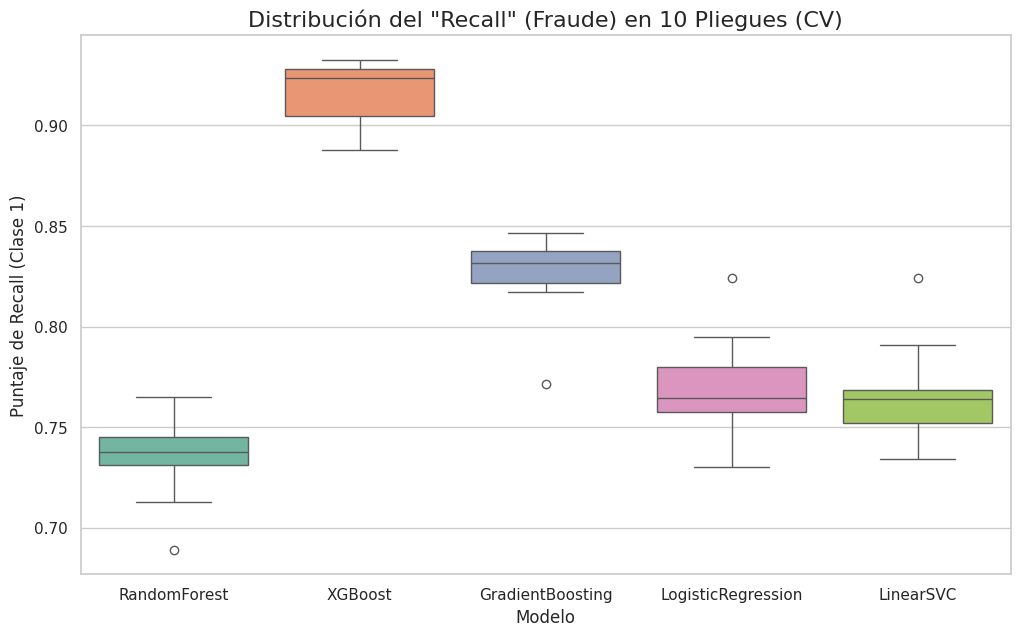


Ejecutando Prueba de Friedman sobre los scores de 'Recall'...
   Estadístico F de Friedman: 35.6718
   Valor-p: 0.0000
   Veredicto: Se detecta una diferencia estadística significativa en el 'Recall' de los modelos.

Fase 3 completada.


In [ ]:
#Validacion Cruzada con Metricas Detalladas

#Importamos las herramientas necesarias
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import scipy.stats as stats

print("\n" + "="*50)
print("[FASE 3: Validacion Cruzada (k=10) con Metricas Detalladas]")
print("Calculando 5 métricas sobre 10 pliegues para 5 modelos...")

N_SPLITS = 10
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

#Definir las Multiples Metricas ---
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1_score': make_scorer(f1_score, zero_division=0),
    'roc_auc': make_scorer(roc_auc_score)
}
#Diccionario para almacenar TODOS los resultados de cross_validate
cv_results_full = {}

print(f"Ejecutando con {N_SPLITS} pliegues...")

for nombre, pipeline in pipelines_completos.items():
    print(f"   Procesando: {nombre}...")
    #Usamos cross_validate para obtener todos los scores de los 10 folds
    scores = cross_validate(pipeline, X_train, y_train,
                             cv=kfold,
                             scoring=scoring_metrics,
                             n_jobs=-1)

    # Guardamos el diccionario completo de scores
    cv_results_full[nombre] = scores

print("Listo")

# --- 3.2. Cuadro 1: Scores Individuales por Pliegue (Fold) ---
print("\n" + "="*50)
print("Cuadro 1: Resultados Detallados de 'Recall' por Pliegue (k=10) ---")

# Extraemos solo los scores de 'recall' de cada modelo
recall_scores_dict = {
    nombre: results['test_recall']
    for nombre, results in cv_results_full.items()
}

# Creamos el DataFrame que pediste
df_recall_folds = pd.DataFrame(recall_scores_dict).T # .T transpone las filas y columnas

# Renombramos las columnas
df_recall_folds.columns = [f'Recall_Fold_{i+1}' for i in range(N_SPLITS)]
df_recall_folds.index.name = 'Modelo'

print(df_recall_folds.to_string(float_format="%.4f"))


# --- 3.3. Cuadro 2: Resumen de Métricas (Promedio y Desv. Estándar) ---
print("\n" + "="*50)
print("Cuadro 2: Resumen de Métricas Promedio en 10 Pliegues (CV) ---")

summary_list = []
for nombre, results in cv_results_full.items():
    summary_list.append({
        'Modelo': nombre,
        'Recall (Media)': results['test_recall'].mean(),
        'Recall (Std)': results['test_recall'].std(),
        'Precision (Media)': results['test_precision'].mean(),
        'F1-Score (Media)': results['test_f1_score'].mean(),
        'ROC-AUC (Media)': results['test_roc_auc'].mean(),
        'Accuracy (Media)': results['test_accuracy'].mean()
    })

df_cv_summary = pd.DataFrame(summary_list).set_index('Modelo')
print(df_cv_summary.to_string(float_format="%.4f"))


# --- 3.4. Análisis Gráfico de Métricas por Pliegues (Recall) ---
print("\nGenerando análisis gráfico de 'Recall' por pliegues...")

# Usamos df_recall_folds (transpuesto) para el boxplot
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_recall_folds.T, palette='Set2') # Usamos .T para que los modelos estén en el eje X
plt.title('Distribución del "Recall" (Fraude) en 10 Pliegues (CV)', fontsize=16)
plt.ylabel('Puntaje de Recall (Clase 1)')
plt.xlabel('Modelo')
plt.show()


# --- 3.5. Opcional: Prueba Estadística de Friedman (sobre Recall) ---
print("\nEjecutando Prueba de Friedman sobre los scores de 'Recall'...")

# Usamos los 10 scores de Recall de cada modelo (del Cuadro 1)
try:
    # Pasamos los valores de df_recall_folds (cada fila es un modelo)
    f_statistic, p_value = stats.friedmanchisquare(*df_recall_folds.values)
    print(f"   Estadístico F de Friedman: {f_statistic:.4f}")
    print(f"   Valor-p: {p_value:.4f}")

    if p_value < 0.05:
        print("   Veredicto: Se detecta una diferencia estadística significativa en el 'Recall' de los modelos.")
    else:
        print("   Veredicto: NO hay diferencia estadística significativa en el 'Recall' de los modelos.")

except ValueError as e:
    print(f"   Error al ejecutar Friedman test: {e}")

print("\nFase 3 completada.")

**Grafico de lineas**


--- [FASE 3 (cont.): Gráfico de Líneas de Recall por Pliegue] ---

Generando gráfico de líneas comparativo...


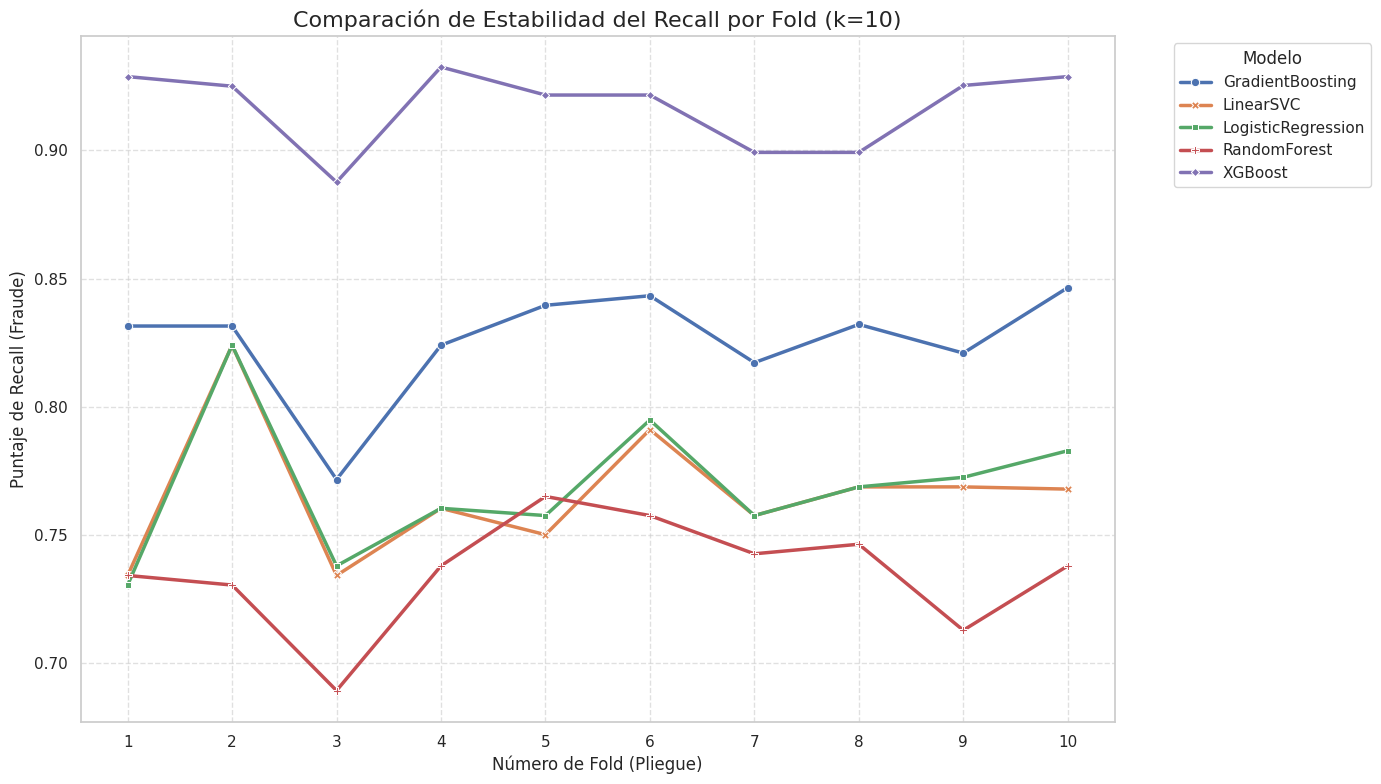

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*50)
print("--- [FASE 3 (cont.): Gráfico de Líneas de Recall por Pliegue] ---")
print("="*50)

# Asumimos que 'df_recall_folds' existe en memoria de la celda anterior.
# Si da error, por favor re-ejecuta el 'Bloque 3'.

try:
    # 1. "Derretir" (melt) el DataFrame de ancho a largo
    # Convertimos de:
    # Modelo | Fold_1 | Fold_2
    # RF     | 0.73   | 0.73
    # A:
    # Modelo | Fold     | Recall
    # RF     | Fold_1   | 0.73
    # RF     | Fold_2   | 0.73

    df_long = df_recall_folds.reset_index().melt(
        id_vars='Modelo',
        var_name='Fold',
        value_name='Recall'
    )

    # 2. Extraer el número del fold para ordenar el eje X correctamente
    df_long['Fold_Num'] = df_long['Fold'].str.replace('Recall_Fold_', '').astype(int)
    df_long = df_long.sort_values(by=['Modelo', 'Fold_Num'])

    # 3. Generar el gráfico de líneas
    print("\nGenerando gráfico de líneas comparativo...")
    plt.figure(figsize=(14, 8))

    sns.lineplot(
        data=df_long,
        x='Fold_Num',
        y='Recall',
        hue='Modelo',  # Un color por modelo
        style='Modelo', # Un estilo de línea/marcador por modelo
        markers=True,   # Poner un marcador en cada punto (fold)
        dashes=False,
        linewidth=2.5
    )

    plt.title('Comparación de Estabilidad del Recall por Fold (k=10)', fontsize=16)
    plt.xlabel('Número de Fold (Pliegue)', fontsize=12)
    plt.ylabel('Puntaje de Recall (Fraude)', fontsize=12)

    # Asegurarnos de que el eje X muestre todos los 10 folds
    plt.xticks(range(1, N_SPLITS + 1))

    # Mover la leyenda fuera del gráfico
    plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True, which='major', linestyle='--', alpha=0.6)
    plt.tight_layout() # Ajustar para que la leyenda no se corte
    plt.show()

except NameError:
    print("\nERROR: No se encontró la variable 'df_recall_folds'.")
    print("Por favor, asegúrate de haber ejecutado el 'Bloque 3' anterior.")
except Exception as e:
    print(f"\nUn error ocurrió al generar el gráfico: {e}")

#6 Evaluación e Interpretación de Resultados
